# COVID-ABS: An Agent-Based Model of COVID-19 Epidemic to Simulate Health and Economic Effects of Social Distancing Interventions

Petrônio C. L. Silva <span itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0002-1202-2552" href="https://orcid.org/0000-0002-1202-2552" target="orcid.widget" rel="noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-right:.5em;" alt="ORCID iD icon"></a></span>, Paulo V. C. Batista <span itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0001-6165-2174" href="https://orcid.org/0000-0001-6165-2174" target="orcid.widget" rel="noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-right:.5em;" alt="ORCID iD icon"></a></span>, Hélder S. Lima <span itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0003-0934-7644" href="https://orcid.org/0000-0003-0934-7644" target="orcid.widget" rel="noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-right:.5em;" alt="ORCID iD icon"></a></span>, Marcos A. Alves <span itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0001-6934-6745" href="https://orcid.org/0000-0001-6934-6745" target="orcid.widget" rel="noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-right:.5em;" alt="ORCID iD icon"></a></span>,  Rodrigo P. Silva <span itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0003-2547-3835" href="https://orcid.org/0000-0003-2547-3835" target="orcid.widget" rel="noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-right:.5em;" alt="ORCID iD icon"></a></span>, Frederico G. Guimarães <span itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0001-9238-8839" href="https://orcid.org/0000-0001-9238-8839" target="orcid.widget" rel="noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-right:.5em;" alt="ORCID iD icon"></a></span>

Chaos, Solitons & Fractals, 2020. Availabe in https://doi.org/10.1016/j.chaos.2020.110088


Preprint availabe in https://arxiv.org/abs/2006.10532

<center>
<table><tr><td><a href="#"><img src="https://avatars1.githubusercontent.com/u/54992196" alt="Grupo de Pesquisa em Ciência de Dados e Inteligência Computacional - {cidic}" width="200"/></a> </td> 
  <td>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</td>
<td><a href="http://www.minds.eng.ufmg.br/"><img src="https://github.com/petroniocandido/pyFTS/raw/master/img/minds_logo_medium.jpeg" alt="MINDS - Machine Intelligence and Data Science Lab" width="100"/></a></td>
</tr>
</table>
</center>


## Installing the package

In [1]:
#!pip3 install git+https://github.com/petroniocandido/COVID19_AgentBasedSimulation.git

In [2]:
#!pip3 install ffmpeg

## Common imports

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import animation, rc
from IPython.display import HTML

from covid_abs.graphics import *
from covid_abs.experiments import *
from covid_abs.network.graph_abs import *
from covid_abs.network.util import *

## Simulations

### Support Functions

In [5]:
def pset(x, property, value):
    x.__dict__[property] = value
    return False


def vertical_isolation(a):
  if a.economical_status == EconomicalStatus.Inactive:
    if a.house is not None:
      a.house.checkin(a)
    return True
  return False


def sleep(a):
    if not new_day(a.iteration) and bed_time(a.iteration):
        return True
    #elif 9 <= a.iteration % 24 <= 11 and 14 <= a.iteration % 24 <= 16:
    #    return True
    return False

def lockdown(a):
    if a.house is not None:
        a.house.checkin(a)
    return True


def conditional_lockdown(a):
    if a.environment.get_statistics()['Infected'] > .05:
        return lockdown(a)
    else:
        return False


isolated = []


def sample_isolated(environment, isolation_rate=.5, list_isolated=isolated):
    for a in environment.population:
        test = np.random.rand()
        if test <= isolation_rate:
            list_isolated.append(a.id)


def check_isolation(list_isolated, agent):
    if agent.id in list_isolated:
        agent.move_to_home()
        return True
    return False


### Global Parameters

In [6]:
global_parameters = dict(

    # General Parameters
    length=300,
    height=300,

    # Demographic
    population_size=100,
    homemates_avg=3,
    homeless_rate=0.0005,
    amplitudes={
        Status.Susceptible: 10,
        Status.Recovered_Immune: 10,
        Status.Infected: 10
    },

    # Epidemiological
    critical_limit=0.01,
    contagion_rate=.9,
    incubation_time=5,
    contagion_time=10,
    recovering_time=20,

    # Economical
    total_wealth=10000000,
    total_business=9,
    minimum_income=900.0,
    minimum_expense=600.0,
    public_gdp_share=0.1,
    business_gdp_share=0.5,
    unemployment_rate=0.12,
    business_distance=20
)

# Custom code

In [7]:
from covid_abs.no_graphics import  *
import matplotlib as pyplot

def plot_statistics(stats):
    

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
    
    for key in statistics['info'][0]:
        y = [e[key] for e in statistics['info']]

        ax1.plot(np.arange(len(y)), y, label=key)
    ax1.set_title('Infection statistics')
        
    for key in statistics['ecom'][0]:
        y = [e[key] for e in statistics['ecom']]

        ax2.plot(np.arange(len(y)), y, label=key)
    ax2.set_title('Economic statistics')

    ax1.legend()
    ax2.legend()
    plt.show()

### Scenario 1 - No measures

In [8]:
scenario1 = dict(
    name='scenario1',
    initial_infected_perc=.05,
    initial_immune_perc=.00,
    contagion_distance=1.,
    callbacks={'on_execute': lambda x: sleep(x) }
)

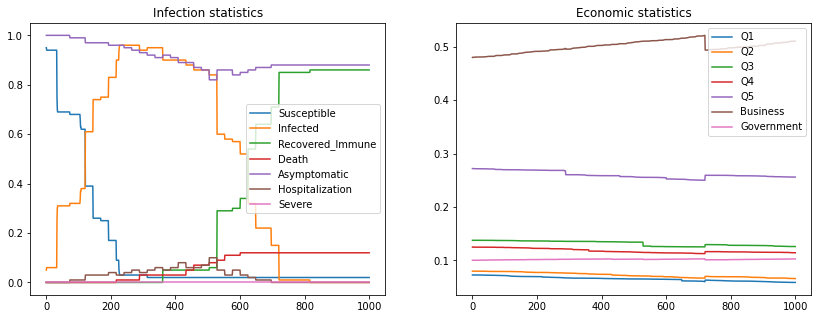

In [10]:
sim = GraphSimulation(**{**global_parameters, **scenario1})

statistics = execute_simulation(sim, iterations=1000)

plot_statistics(statistics)

### Scenario 2 - Lockdown

In [11]:
scenario2 = dict(
    name='scenario2',
    initial_infected_perc=.05,
    initial_immune_perc=.00,
    contagion_distance=1.,
    callbacks={
        'on_execute': lambda x: sleep(x),
        'on_person_move': lambda x: lockdown(x)
    }
)

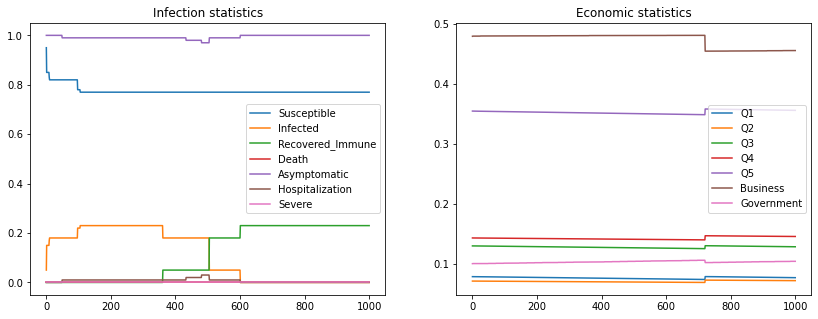

In [12]:
sim = GraphSimulation(**{**global_parameters, **scenario2})

statistics = execute_simulation(sim, iterations=1000)

plot_statistics(statistics)

# Sample code

#### Execution Sample

In [13]:
from covid_abs.graphics import  *
from covid_abs.network.graph_abs import *
import time

np.random.seed(1)

sim = Simulation(**{**global_parameters, **scenario0})

anim = execute_simulation(sim, iterations=50, iteration_time=200)

#rc('animation', html='jshtml', embed_limit= 2**128)
rc('animation', html='html5', embed_limit= 2**128)
anim

#save_gif(anim, 'do_nothing.gif')

NameError: name 'scenario0' is not defined

In [14]:
from covid_abs.graphics import  *
from covid_abs.network.graph_abs import *
import time

np.random.seed(1)

sim = GraphSimulation(**{**global_parameters, **scenario0})

anim = execute_graphsimulation(sim, iterations=1440, iteration_time=50)

#rc('animation', html='jshtml', embed_limit= 2**128)
rc('animation', html='html5', embed_limit= 2**128)
anim

#save_gif(anim, 'do_nothing.gif')

NameError: name 'scenario0' is not defined

KeyboardInterrupt: 

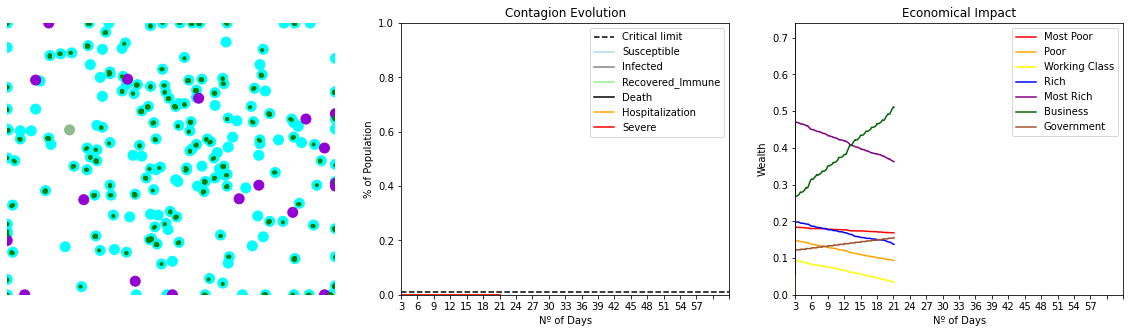

In [6]:
anim = execute_graphsimulation(sim, iterations=1440, iteration_time=25)

#rc('animation', html='jshtml', embed_limit= 2**128)
rc('animation', html='html5', embed_limit= 2**128)
anim

#### Experiment Batch Execution 

In [ ]:
from covid_abs.network.graph_abs import *

batch_experiment(35, 1440, "scenario0.csv",
                     simulation_type=GraphSimulation,
                     verbose='experiments',
                     **{**global_parameters, **scenario0}
                     )

In [ ]:
from covid_abs.experiments import plot_graph_batch_results

df = pd.read_csv('scenario0.csv')

plot_graph_batch_results(df, epidem=False)

plt.tight_layout()

### Scenario 1 - Do Nothing

In [15]:
scenario1 = dict(
    name='scenario1',
    initial_infected_perc=.01,
    initial_immune_perc=.01,
    contagion_distance=1.,
    callbacks={'on_execute': lambda x: sleep(x) }
)

#### Execution Sample

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1440x360', '-pix_fmt', 'rgba', '-r', '40.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmp4y572bh_/temp.m4v']' returned non-zero exit status 255.

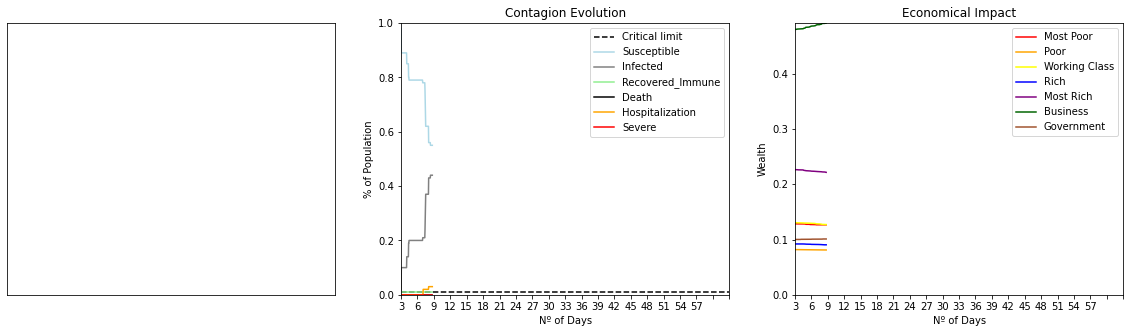

In [16]:
from covid_abs.graphics import  *
from covid_abs.network.graph_abs import *

np.random.seed(1)

sim = GraphSimulation(**{**global_parameters, **scenario1})

anim = execute_graphsimulation(sim, iterations=1440, iteration_time=25)

#rc('animation', html='jshtml', embed_limit= 2**128)
rc('animation', html='html5', embed_limit= 2**128)
anim

#save_gif(anim, 'do_nothing.gif')

#### Experiment Batch Execution 

In [ ]:
from covid_abs.network.graph_abs import *

batch_experiment(35, 1440, "scenario1.csv",
                     simulation_type=GraphSimulation,
                     verbose='experiments',
                     **{**global_parameters, **scenario1}
                     )

In [ ]:
from covid_abs.experiments import plot_graph_batch_results

df = pd.read_csv('scenario1.csv')

plot_graph_batch_results(df)

plt.tight_layout()

### Scenario 2 - Lockdown

In [35]:
scenario2 = dict(
    name='scenario2',
    initial_infected_perc=.01,
    initial_immune_perc=.01,
    contagion_distance=1.,
    callbacks={
        'on_execute': lambda x: sleep(x),
        'on_person_move': lambda x: lockdown(x)
    }
)

#### Execution Sample

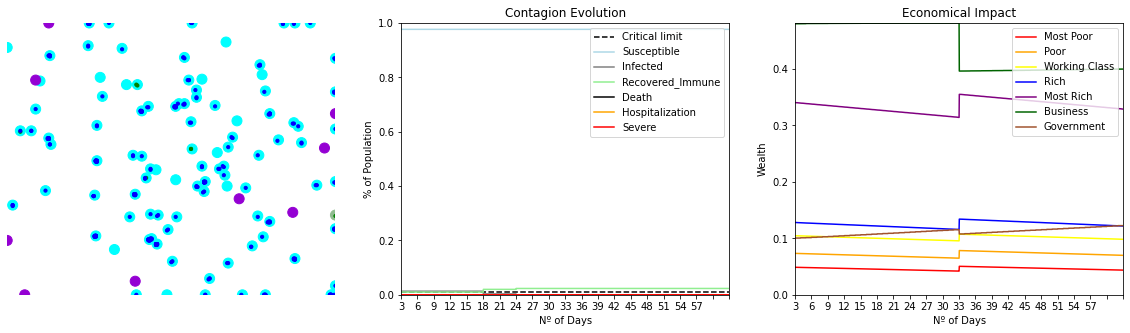

In [37]:
from covid_abs.graphics import  *
from covid_abs.network.graph_abs import *

np.random.seed(1)

sim = GraphSimulation(**{**global_parameters, **scenario2})

anim = execute_graphsimulation(sim, iterations=1440, iteration_time=25)

#rc('animation', html='jshtml', embed_limit= 2**128)
rc('animation', html='html5', embed_limit= 2**128)
anim

#save_gif(anim, 'do_nothing.gif')

#### Experiment Batch Execution 

In [ ]:
from covid_abs.network.graph_abs import *

batch_experiment(35, 1440, "scenario2.csv",
                     simulation_type=GraphSimulation,
                     verbose='experiments',
                     **{**global_parameters, **scenario2}
                     )

In [ ]:
from covid_abs.experiments import plot_graph_batch_results

df = pd.read_csv('scenario2.csv')

plot_graph_batch_results(df)

plt.tight_layout()

### Scenario 3 - Conditional Lockdown

In [ ]:
scenario3 = dict(
    name='scenario3',
    initial_infected_perc=.01,
    initial_immune_perc=.01,
    contagion_distance=1.,
    callbacks={
        'on_execute': lambda x: sleep(x),
        'on_person_move': lambda x: conditional_lockdown(x)
    }
)

#### Execution Sample

In [ ]:
from covid_abs.graphics import  *
from covid_abs.network.graph_abs import *

np.random.seed(1)

sim = GraphSimulation(**{**global_parameters, **scenario3})

anim = execute_graphsimulation(sim, iterations=1440, iteration_time=25)

#rc('animation', html='jshtml', embed_limit= 2**128)
rc('animation', html='html5', embed_limit= 2**128)
anim

#save_gif(anim, 'do_nothing.gif')

#### Experiment Batch Execution 

In [ ]:
from covid_abs.network.graph_abs import *

batch_experiment(35, 1440, "scenario3.csv",
                     simulation_type=GraphSimulation,
                     verbose='experiments',
                     **{**global_parameters, **scenario3}
                     )

In [ ]:
from covid_abs.experiments import plot_graph_batch_results

df = pd.read_csv('scenario3.csv')

plot_graph_batch_results(df)

plt.tight_layout()

### Scenario 4 - Vertical Isolation


In [ ]:
scenario4 = dict(
    name='scenario4',
    initial_infected_perc=.01,
    initial_immune_perc=.01,
    contagion_distance=1.,
    callbacks={
        'on_execute': lambda x: sleep(x),
        'on_person_move': lambda x: vertical_isolation(x)
    }
)

#### Execution Sample

In [ ]:
from covid_abs.graphics import  *
from covid_abs.network.graph_abs import *

np.random.seed(1)

sim = GraphSimulation(**{**global_parameters, **scenario4})

anim = execute_graphsimulation(sim, iterations=1440, iteration_time=25)

#rc('animation', html='jshtml', embed_limit= 2**128)
rc('animation', html='html5', embed_limit= 2**128)
anim

#save_gif(anim, 'do_nothing.gif')

#### Experiment Batch Execution 

In [ ]:
from covid_abs.network.graph_abs import *

batch_experiment(35, 1440, "scenario4.csv",
                     simulation_type=GraphSimulation,
                     verbose='experiments',
                     **{**global_parameters, **scenario4}
                     )

In [ ]:
from covid_abs.experiments import plot_graph_batch_results

df = pd.read_csv('scenario4.csv')

plot_graph_batch_results(df)

plt.tight_layout()

### Scenario 5 - 50% of Population Isolation

In [ ]:
isolated = []
scenario5 = dict(
    name='scenario5',
    initial_infected_perc=.01,
    initial_immune_perc=.01,
    contagion_distance=1.,
    callbacks={
        #'on_execute': lambda x: sleep(x),
        'post_initialize': lambda x: sample_isolated(x, isolation_rate=.7, list_isolated=isolated),
        'on_person_move': lambda x: check_isolation(isolated, x)
    }
)

#### Execution Sample

In [ ]:
from covid_abs.graphics import  *
from covid_abs.network.graph_abs import *

np.random.seed(1)

sim = GraphSimulation(**{**global_parameters, **scenario5})

anim = execute_graphsimulation(sim, iterations=1440, iteration_time=25)

#rc('animation', html='jshtml', embed_limit= 2**128)
rc('animation', html='html5', embed_limit= 2**128)
anim

#save_gif(anim, 'do_nothing.gif')

#### Experiment Batch Execution 

In [ ]:
from covid_abs.network.graph_abs import *

batch_experiment(35, 1440, "scenario5.csv",
                     simulation_type=GraphSimulation,
                     verbose='experiments',
                     **{**global_parameters, **scenario5}
                     )

In [ ]:
from covid_abs.experiments import plot_graph_batch_results

df = pd.read_csv('scenario5.csv')

plot_graph_batch_results(df)

plt.tight_layout()

#### Other isolation levels

In [ ]:
scenarios = []

for rate in [.4, .5, .6, .7, .8, .9]:
    tmp = dict(
        name='partialisolation{}'.format(rate),
        initial_infected_perc=.01,
        initial_immune_perc=.01,
        contagion_distance=.05,
        callbacks={
            'post_initialize': lambda x: sample_isolated(x, isolation_rate=rate, list_isolated=isolated),
            'on_person_move': lambda x: check_isolation(isolated, x)
        }
    )
    scenarios.append(tmp)
    
for scenario in scenarios:  #scenario0, scenario1, scenario2, scenario3, scenario4, scenario5, scenario6, scenario7, scenario8, scenario9]:
    batch_experiment(15, 1440, "{}.csv".format(scenario['name']),
                     simulation_type=GraphSimulation,
                     verbose='experiments',
                     **{**global_parameters, **scenario}
                     )

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 3])
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                                   AutoMinorLocator)

isolation_levels = [.3, .4, .5, .6, .7, .8, .9]

tick_unit=72

x = [i for i in range(0, 1440)]

for ct, isolation_level in enumerate(isolation_levels):
  df = pd.read_csv('partialisolation{}.csv'.format(isolation_level))
  df2 = df[(df['Metric'] == 'Infected')]
  ax.plot(x, df2['Avg'].values, label=str(isolation_level))
  #print(str(isolation_level), max(df2['Avg'].values))

#ax.set_title("Infection Curve by Isolation Level")
ax.set_ylabel("% of population")
ax.set_xlabel("Days")
tickslabels = [str(i//24) for i in range(0, 1440, tick_unit)]
ax.xaxis.set_major_locator(MultipleLocator(tick_unit))
ax.set_xticklabels(tickslabels)

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='top right')


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 3])
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                                   AutoMinorLocator)

isolation_levels = [.3, .4, .5, .6, .7, .8, .9]

tick_unit=72

x = [i for i in range(0, 1440)]

for ct, isolation_level in enumerate(isolation_levels):
  df = pd.read_csv('partialisolation{}.csv'.format(isolation_level))
  df2 = df[(df['Metric'] == 'Q5')]
  ax.plot(x, df2['Avg'].values, label=str(isolation_level))
  #print(str(isolation_level), max(df2['Avg'].values))

#ax.set_title("Infection Curve by Isolation Level")
ax.set_ylabel("% of GDP")
ax.set_xlabel("Days")
tickslabels = [str(i//24) for i in range(0, 1440, tick_unit)]
ax.xaxis.set_major_locator(MultipleLocator(tick_unit))
ax.set_xticklabels(tickslabels)

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='top right')


In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=[7, 5])
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                                   AutoMinorLocator)

deaths = []
i_peak = []
vals = []
errs = []
isolation_levels = (.4, .5, .6, .7, .8, .9)

for isolation_level in isolation_levels:
  df = pd.read_csv('partialisolation{}.csv2'.format(isolation_level))
  df2 = df[(df['Metric'] == 'Infected')]
  #min_max = np.max(df2['Min'].values)
  avg_max = np.max(df2['Avg'].values)
  i_peak.append(avg_max)
  #max_max = np.max(df2['Max'].values)
  it_max = np.min(df2[(df['Avg'] == avg_max)]['Iteration'].values)
  #ax.plot(df2['Avg'].values, label=get_label(i))
  vals.append(it_max // 24)

  df3 = df[(df['Metric'] == 'Death')]
  avg_max2 = np.max(df3['Avg'].values)
  deaths.append(avg_max2)

ix = [1,2,3,4,5,6]

ax[0].bar(ix, i_peak, color='white',  edgecolor='black', hatch='//')
ax[0].set_ylabel("% of Infected")
ax[0].set_xlabel("Scenario")
ax[0].set_title("$I_P$ - Infection Peak")

ax[1].bar(ix, vals, color='white',  edgecolor='black', hatch='//')
ax[1].set_ylabel("Number of Days")
ax[1].set_xlabel("Scenario")
ax[1].set_title("$T_{IP}$ - Number of Days to Reach $I_P$")

ax[2].bar(ix, deaths, color='white',  edgecolor='black', hatch='//')
ax[2].set_ylabel("% of Deaths")
ax[2].set_xlabel("Scenario")
ax[2].set_title("$D_t$ - Total Number of Deaths")

plt.tight_layout()


In [ ]:
def next(it, its, start):
  if it not in its:
    for k in its[start:]:
      if k > it:
        return k
  else:
    return it

for sc in [.3]: #.4, .5, .6, .7, .8, .9]:

  filename = 'partialisolation{}.csv'.format(sc)

  df = pd.read_csv(filename)
  metrics = df['Metric'].unique()
  iterations = df['Iteration'].unique()
  columns = ['Min','Avg','Std','Max']
  rows = []
  last_ix = 0
  for iteration in range(0,1440):

    print(iteration)

    ix = next(iteration, iterations, last_ix)

    for metric in metrics:
      row = [iteration, metric]
      for column in columns:
        row.append(df[(df['Iteration']==ix) & (df['Metric']==metric)][column].values[0])

      rows.append(row)

    last_ix = int(np.where(iterations == ix)[0])

  df2 = pd.DataFrame(rows, columns=['Iteration','Metric','Min','Avg','Std','Max'])

  df2.to_csv(filename)
  

### Scenario 6 - Use of Masks

In [ ]:
scenario6 = dict(
    name='scenario6',
    initial_infected_perc=.01,
    initial_immune_perc=.01,
    contagion_distance=.05,
    callbacks={
        'on_execute': lambda x: sleep(x) ,
        'on_initialize': lambda x: pset(x, 'contagion_rate', 0.1)
    }
)

#### Execution Sample

In [ ]:
from covid_abs.graphics import  *
from covid_abs.network.graph_abs import *

np.random.seed(1)

sim = GraphSimulation(**{**global_parameters, **scenario6})

anim = execute_graphsimulation(sim, iterations=1440, iteration_time=25)

#rc('animation', html='jshtml', embed_limit= 2**128)
rc('animation', html='html5', embed_limit= 2**128)
anim

#save_gif(anim, 'do_nothing.gif')

#### Experiment Batch Execution 

In [ ]:
from covid_abs.network.graph_abs import *

batch_experiment(35, 1440, "scenario6.csv",
                     simulation_type=GraphSimulation,
                     verbose='experiments',
                     **{**global_parameters, **scenario8}
                     )

In [ ]:
from covid_abs.experiments import plot_graph_batch_results

df = pd.read_csv('scenario6.csv')

plot_graph_batch_results(df)

plt.tight_layout()

### Scenario 7 - Masks And 50% of Social Isolation

In [ ]:
scenario7 = dict(
    name='scenario7',
    initial_infected_perc=.01,
    initial_immune_perc=.01,
    contagion_distance=.05,
    callbacks={
        'on_execute': lambda x: sleep(x) ,
        'post_initialize': lambda x: sample_isolated(x, isolation_rate=.6, list_isolated=isolated),
        'on_person_move': lambda x: check_isolation(isolated, x),
        'on_initialize': lambda x: pset(x, 'contagion_rate', 0.1)
    }
)

#### Execution Sample

In [ ]:
from covid_abs.graphics import  *
from covid_abs.network.graph_abs import *

np.random.seed(1)

sim = GraphSimulation(**{**global_parameters, **scenario7})

anim = execute_graphsimulation(sim, iterations=1440, iteration_time=25)

#rc('animation', html='jshtml', embed_limit= 2**128)
rc('animation', html='html5', embed_limit= 2**128)
anim

#save_gif(anim, 'do_nothing.gif')

#### Experiment Batch Execution 

In [ ]:
from covid_abs.network.graph_abs import *

batch_experiment(35, 1440, "scenario7.csv",
                     simulation_type=GraphSimulation,
                     verbose='experiments',
                     **{**global_parameters, **scenario9}
                     )

In [ ]:
from covid_abs.experiments import plot_graph_batch_results

df = pd.read_csv('scenario7.csv')

plot_graph_batch_results(df)

plt.tight_layout()

## Analysis

Acho que devemos fazer uma análise qualitativa dos gráficos e uma análise quantitativa e comparativa dos cenários em termos das seguintes métricas:
- número total de mortes 
- número total de infectados
- tempo do pico 
- perdas % em renda das empresas em relação ao cenário 0 
- perdas % em renda das famílias em relação ao cenário 0


### Common Codes

In [ ]:
def get_label(ix):
  return 'Scenario {}'.format(ix)

def get_name(ix):
  return 'scenario{}'.format(ix)

def get_df(ix):
  return pd.read_csv(get_name(ix)+".csv")

#get_df(0).head()

### Evolution of Deaths by Scenario

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 5])
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                                   AutoMinorLocator)
for i in range(1,8):
  df = get_df(i)[['Iteration','Metric','Avg']]
  df2 = df[(df['Metric'] == 'Death')]
  ax.plot(df2['Avg'].values, label=get_label(i))

tick_unit=72

ax.set_title("Evolution of Deaths by Scenario")
ax.set_ylabel("% of population")
ax.set_xlabel("Days")
tickslabels = [str(i//24) for i in range(0, 1440, tick_unit)]
ax.xaxis.set_major_locator(MultipleLocator(tick_unit))
ax.set_xticklabels(tickslabels)

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='top right')

### Evolution of Infection by Scenario

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 5])
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                                   AutoMinorLocator)
for i in range(1,8):
  df = get_df(i)[['Iteration','Metric','Avg']]
  df2 = df[(df['Metric'] == 'Infected')]
  ax.plot(df2['Avg'].values, label=get_label(i))

tick_unit=72

ax.set_title("Evolution of Infection by Scenario")
ax.set_ylabel("% of population")
ax.set_xlabel("Days")
tickslabels = [str(i//24) for i in range(0, 1440, tick_unit)]
ax.xaxis.set_major_locator(MultipleLocator(tick_unit))
ax.set_xticklabels(tickslabels)

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='top right')

### Number of Days to Reach the Infection Peak

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=[7, 5])
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                                   AutoMinorLocator)

deaths = []
i_peak = []
vals = []
errs = []
for i in range(1,8):
  df = get_df(i)
  df2 = df[(df['Metric'] == 'Infected')]
  #min_max = np.max(df2['Min'].values)
  avg_max = np.max(df2['Avg'].values)
  i_peak.append(avg_max)
  #max_max = np.max(df2['Max'].values)
  it_max = np.min(df2[(df['Avg'] == avg_max)]['Iteration'].values)
  #ax.plot(df2['Avg'].values, label=get_label(i))
  vals.append(it_max // 24)

  df3 = df[(df['Metric'] == 'Death')]
  avg_max2 = np.max(df3['Avg'].values)
  deaths.append(avg_max2)

ax[0].bar([i for i in range(1,8)], i_peak, color='white',  edgecolor='black', hatch='//')
ax[0].set_ylabel("% of Infected")
ax[0].set_xlabel("Scenario")
ax[0].set_title("$I_P$ - Infection Peak")

ax[1].bar([i for i in range(1,8)], vals, color='white',  edgecolor='black', hatch='//')
ax[1].set_ylabel("Number of Days")
ax[1].set_xlabel("Scenario")
ax[1].set_title("$T_{IP}$ - Number of Days to Reach $I_P$")

ax[2].bar([i for i in range(1,8)], deaths, color='white',  edgecolor='black', hatch='//')
ax[2].set_ylabel("% of Deaths")
ax[2].set_xlabel("Scenario")
ax[2].set_title("$D_t$ - Total Number of Deaths")

plt.tight_layout()


### GDP Evolution By Social Stratum and Scenario

In [ ]:
from covid_abs.graphics import legend_ecom
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

metrics = legend_ecom.keys()

fig, ax = plt.subplots(nrows=len(metrics), ncols=1, figsize=[10, 25])

tick_unit=72

for i in range(0,10):                                   
  df = get_df(i)[['Iteration','Metric','Avg']]

  for cm, metric in enumerate(metrics):
    df2 = df[(df['Metric'] == metric)]
    ax[cm].plot(df2['Avg'].values, label=get_label(i))

tickslabels = [str(i//24) for i in range(0, 1440, tick_unit)]

for cm, metric in enumerate(metrics):
  ax[cm].set_title(legend_ecom[metric])
  ax[cm].set_ylabel("% of GDP")
  ax[cm].set_xlabel("Days")
  ax[cm].xaxis.set_major_locator(MultipleLocator(tick_unit))
  ax[cm].set_xticklabels(tickslabels)

  handles, labels = ax[cm].get_legend_handles_labels()
  lgd = ax[cm].legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

plt.tight_layout()

### Scenarios Final GDP Compared with Scenario 0

In [ ]:
from covid_abs.graphics import legend_ecom
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

A1 = ['Q1','Q2','Q3','Q4','Q5']

legend = {'A1': '$W^{A1}_s$ - People',
          'Business': '$W^{A3}_s$ - Business',
          'Government': '$W^{A4}_s$ - Government',}

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=[10, 7])

metrics = [k for k in legend.keys()]

baseline = {'A1': 0.0 }
baseline_stop = {'A1': 0.0 }
df = get_df(0)
for cm, metric in enumerate(legend_ecom.keys()):
  #mn_it = np.min(df['Iteration'].values)
  mx_it = np.max(df['Iteration'].values)
  _start = df[(df['Metric'] == metric) & (df['Iteration'] == 0)]['Avg'].values[-1]
  _stop = df[(df['Metric'] == metric) & (df['Iteration'] == mx_it)]['Avg'].values[-1]
  #_std = df[(df['Metric'] == metric) & (df['Iteration'] == mx_it)]['Std'].values[-1]
  diff = _start - _stop
  #baseline[metric].append(diff)
  if metric in A1:
    #baseline['A1'] += _stop
    baseline['A1'] += diff
    baseline_stop['A1'] += _stop
  else:
    baseline[metric] = diff
    baseline_stop[metric] = _stop

values = {}
colors = {}
std = {}

for i in range(1,8):                                   
  df = get_df(i)
  for cm, metric in enumerate(metrics):
    if metric not in values:
      values[metric] = []
      colors[metric] = []
      std[metric] = []
    
    mx_it = np.max(df['Iteration'].values)

    if metric == 'A1':
      _stop = 0
      _std = 0
      for m2 in A1:
        _stop += df[(df['Metric'] == m2) & (df['Iteration'] == mx_it)]['Avg'].values[-1]
        _std += df[(df['Metric'] == m2) & (df['Iteration'] == mx_it)]['Std'].values[-1]

    else:
      _stop = df[(df['Metric'] == metric) & (df['Iteration'] == mx_it)]['Avg'].values[-1]
      _std = df[(df['Metric'] == metric) & (df['Iteration'] == mx_it)]['Std'].values[-1]
    
    #m = (_stop - baseline[metric])/baseline[metric]
    m = (_stop - baseline_stop[metric])/baseline_stop[metric]
    values[metric].append(m)
    colors[metric].append('//' if m >= 0 else '\\\\' )
    #diff = _start - _stop
    #values[metric].append(diff)
    std[metric].append(_std)
    #colors[metric].append('blue' if diff >= 0 else 'red' )
    #baseline[metric] = _start - stop
    

for cm, metric in enumerate(metrics):
  bars = ax[cm].bar([i for i in range(1,8)], values[metric], color='white',  edgecolor='black',
                    capsize=7, yerr=std[metric])
  for ix, bar in enumerate(bars):
    bar.set_hatch(colors[metric][ix])
  ax[cm].set_ylim([-.25, .25])
  ax[cm].set_ylabel("% of GDP")
  ax[cm].set_xlabel("Scenario")
  ax[cm].set_title(legend[metric])
  ax[cm].axhline(y=0, color='black')


plt.tight_layout()


In [ ]:
def next(it, its, start):
  if it not in its:
    for k in its[start:]:
      if k > it:
        return k
  else:
    return it

for sc in range(2,8):

  filename = 'scenario{}.csv'.format(sc)

  df = pd.read_csv(filename)
  metrics = df['Metric'].unique()
  iterations = df['Iteration'].unique()
  columns = ['Min','Avg','Std','Max']
  rows = []
  last_ix = 0
  for iteration in range(0,1440):

    print(iteration)

    ix = next(iteration, iterations, last_ix)

    for metric in metrics:
      row = [iteration, metric]
      for column in columns:
        row.append(df[(df['Iteration']==ix) & (df['Metric']==metric)][column].values[0])

      rows.append(row)

    last_ix = int(np.where(iterations == ix)[0])

  df2 = pd.DataFrame(rows, columns=['Iteration','Metric','Min','Avg','Std','Max'])

  df2.to_csv(filename + '2')
  

In [ ]:

def plot_graph_batch_results(df, health_metrics=('Susceptible', 'Infected', 'Hospitalization', 'Severe', 'Recovered_Immune', 'Death'),
                       ecom_metrics=('Q1', 'Q2', 'Q3', 'Q4', 'Q5','Business','Government'), **kwargs):

    from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                                   AutoMinorLocator)

    iterations = max(df['Iteration'].values) + 1

    tick_unit = kwargs.get('tick_unit', 72)

    tickslabels = [str(i // 24) for i in range(0, iterations, tick_unit)]

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[20, 5])

    ax[0].set_title('Average Contagion Evolution')
    ax[0].set_xlabel("Nº of Days")
    ax[0].set_ylabel("% of Population")
    ax[0].set_xlim((0, iterations))
    ax[0].xaxis.set_major_locator(MultipleLocator(tick_unit))
    ax[0].set_xticklabels(tickslabels)

    for col in health_metrics:
        means = df[(df["Metric"] == col)]['Avg'].values
        std = df[(df["Metric"] == col)]['Std'].values
        plot_mean_std(ax[0], means, std, legend=col, color=color1(col))

    handles, labels = ax[0].get_legend_handles_labels()
    lgd = ax[0].legend(handles, labels, loc='top right')

    ax[1].set_title('Average Economical Impact')
    ax[1].set_xlabel("Nº of Days")
    ax[1].set_ylabel("% of Wealth")
    ax[1].set_xlim((0, iterations))
    ax[1].xaxis.set_major_locator(MultipleLocator(tick_unit))
    ax[1].set_xticklabels(tickslabels)

    for col in ecom_metrics:
        means = df[(df["Metric"] == col)]['Avg'].values
        #n_mean = np.interp(means, (mmin, mmax), (0, 1))
        std = df[(df["Metric"] == col)]['Std'].values
        #n_std = np.interp(std, (smin, smax), (0, 1))
        #ax[1].plot(means, label=legend_ecom[col])
        # std = np.log10(df[(df["Metric"] == col)]['Std'].values)
        plot_mean_std(ax[1], means, std, legend=legend_ecom[col], color=color3(col))

    handles, labels = ax[1].get_legend_handles_labels()
    lgd = ax[1].legend(handles, labels, loc='top left')

In [ ]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                                   AutoMinorLocator)
from covid_abs.graphics import color3
from covid_abs.experiments import plot_mean_std

A1 = ['Q1','Q2','Q3','Q4','Q5']

health_metrics=('Susceptible', 'Infected', 'Hospitalization', 'Severe', 'Recovered_Immune', 'Death')
ecom_metrics=('Q1', 'Q2', 'Q3', 'Q4', 'Q5','Business','Government')

health_legend={'Susceptible': '$S_t$ - Susceptible', 'Infected':'$I_t$ - Infected', 
               'Hospitalization':'$S^H_t$ - Hospitalization', 'Severe':'$I^S_t$ - Severe', 
               'Recovered_Immune':'$R_t$ - Recovered', 'Death':'$D_t$ - Death'}

ecom_legend = {'A1': '$W^{A1}_t$ - People',
          'Business': '$W^{A3}_t$ - Business',
          'Government': '$W^{A4}_t$ - Government',}

colors = {'A1': 'purple',
          'Business': 'red',
          'Government': 'brown',}

df = get_df(0)

epidem = False

iterations = max(df['Iteration'].values) + 1

tick_unit = 72 #kwargs.get('tick_unit', 72)

tickslabels = [str(i // 24) for i in range(0, iterations, tick_unit)]



fig, ax = plt.subplots(nrows=1, ncols=1 if not epidem else 2,
                       figsize=[7, 4])

if epidem:
  ep_ax = ax[0]
  ep_ax.set_title('Average Epidemiological Evolution')
  ep_ax.set_xlabel("Nº of Days")
  ep_ax.set_ylabel("% of Population")
  ep_ax.set_xlim((0, iterations))
  ep_ax.xaxis.set_major_locator(MultipleLocator(tick_unit))
  ep_ax.set_xticklabels(tickslabels)

  for col in health_metrics:
      means = df[(df["Metric"] == col)]['Avg'].values
      std = df[(df["Metric"] == col)]['Std'].values
      plot_mean_std(ep_ax, means, std, legend=health_legend[col], color=color1(col))

  handles, labels = ep_ax.get_legend_handles_labels()
  lgd = ep_ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

ec_ax = ax[1] if epidem else ax

ec_ax.set_title('Average Economical Impact')
ec_ax.set_xlabel("Nº of Days")
ec_ax.set_ylabel("% of GDP")
ec_ax.set_xlim((0, iterations))
ec_ax.xaxis.set_major_locator(MultipleLocator(tick_unit))
ec_ax.set_xticklabels(tickslabels)

for col in ecom_legend.keys():
  if col == 'A1':
    means = np.zeros(iterations)
    std = np.zeros(iterations)
    for m2 in A1: 
      means += df[(df["Metric"] == m2)]['Avg'].values  
      std += df[(df["Metric"] == m2)]['Std'].values
  else:  
    means = df[(df["Metric"] == col)]['Avg'].values
    std = df[(df["Metric"] == col)]['Std'].values

  #print(means)
      
  l = len(means)
  lb = [means[k] - std[k] for k in range(l)]
  ub = [means[k] + std[k] for k in range(l)]

  ec_ax.fill_between(range(l), ub, lb,
                  color=colors[col], alpha=.4)
  # plot the mean on top
  ec_ax.plot(range(l), means, colors[col], label=ecom_legend[col])

handles, labels = ec_ax.get_legend_handles_labels()
lgd = ec_ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

plt.tight_layout()


In [ ]:
from covid_abs.graphics import legend_ecom
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

A1 = ['Q1','Q2','Q3','Q4','Q5']

legend = {'A1': '$W^{A1}_s$ - People',
          'Business': '$W^{A3}_s$ - Business',
          'Government': '$W^{A4}_s$ - Government',}

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[12, 4])

metrics = [k for k in legend.keys()]

baseline = {'A1': 0.0 }
baseline_stop = {'A1': 0.0 }
df = get_df(0)
for cm, metric in enumerate(legend_ecom.keys()):
  #mn_it = np.min(df['Iteration'].values)
  mx_it = np.max(df['Iteration'].values)
  _start = df[(df['Metric'] == metric) & (df['Iteration'] == 0)]['Avg'].values[-1]
  _stop = df[(df['Metric'] == metric) & (df['Iteration'] == mx_it)]['Avg'].values[-1]
  #_std = df[(df['Metric'] == metric) & (df['Iteration'] == mx_it)]['Std'].values[-1]
  diff = _start - _stop
  #baseline[metric].append(diff)
  if metric in A1:
    #baseline['A1'] += _stop
    baseline['A1'] += diff
    baseline_stop['A1'] += _stop
  else:
    baseline[metric] = diff
    baseline_stop[metric] = _stop

values = {}
colors = {}
std = {}
deaths = {}

for i in range(1,8):                                   
  df = get_df(i)
  deaths[i] = df[(df['Metric'] == 'Death') & (df['Iteration'] == 1339)]['Avg'].values[-1]
  for cm, metric in enumerate(metrics):
    if metric not in values:
      values[metric] = []
      colors[metric] = []
      std[metric] = []
    
    mx_it = np.max(df['Iteration'].values)

    if metric == 'A1':
      _stop = 0
      _std = 0
      for m2 in A1:
        _stop += df[(df['Metric'] == m2) & (df['Iteration'] == mx_it)]['Avg'].values[-1]
        _std += df[(df['Metric'] == m2) & (df['Iteration'] == mx_it)]['Std'].values[-1]

    else:
      _stop = df[(df['Metric'] == metric) & (df['Iteration'] == mx_it)]['Avg'].values[-1]
      _std = df[(df['Metric'] == metric) & (df['Iteration'] == mx_it)]['Std'].values[-1]
    
    #m = (_stop - baseline[metric])/baseline[metric]
    m = (_stop - baseline_stop[metric])/baseline_stop[metric]
    values[metric].append(m)
    colors[metric].append('//' if m >= 0 else '\\\\' )
    #diff = _start - _stop
    #values[metric].append(diff)
    std[metric].append(_std)
    #colors[metric].append('blue' if diff >= 0 else 'red' )
    #baseline[metric] = _start - stop
    
markers = ['s','+', '*','X','D', '^','o']

for cm, metric in enumerate(metrics):

  #ax[cm].scatter(values[metric], [k for k in deaths.values()])

  for i in range(7):
    #ax[cm].text(values[metric][i], deaths[i+1], str(i+1), fontsize=15)
    #ax[cm].annotate(str(i+1), (values[metric][i], deaths[i+1]))
    ax[cm].scatter(values[metric][i], deaths[i+1], s=100, marker=markers[i], color='black', label='Scenario {}'.format(i+1),)

  ax[cm].set_xlim((-0.21, .2))
  ax[cm].set_ylim((-0.01, .12))
  ax[cm].set_xlabel('% of Wealth Increase')
  ax[cm].set_ylabel('% of Deaths')
  ax[cm].set_title(legend[metric])

handles, labels = ax[-1].get_legend_handles_labels()
lgd = ax[-1].legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
  

plt.tight_layout()


In [ ]:
for i in range(7):
  print(i)